In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


In [147]:
# formatting variables
colors = ['#FAF9F6', '#ffe066', '#ffcf1d'] # light grey and 2 yellows (for Iowa)

# custom yellow gradient for heatmaps
yellow = LinearSegmentedColormap.from_list(
    "yellow", ["#FAF9F6", "#ffe066", "#ffcf1d"], N=256
)

My initial research questions:

1.	Is there a correlation between temperature and violent crime incidents (e.g., assault, theft)?
2.
*Hypothesis*: Higher temperatures may be associated with increased rates of violent crimes, based on prior research connecting heat and aggression.
3.	Do weather conditions (e.g., precipitation, wind) help predict whether a crime is violent?
4.
*Hypothesis*: Certain combinations of weather factors could provide signals for predicting crime severity.
5.	Does the time of day influence whether a crime is violent?
6.
*Hypothesis*: Crimes may vary in severity across times of day, with some types more likely during periods of high activity.

# load in data

In [3]:
# load data
merged_df = pd.read_csv('merged_data_new.csv')

# display basic info
merged_df.info()
display(merged_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Case Number           454 non-null    object 
 1   Classification        454 non-null    object 
 2   Date/Time Occurred    454 non-null    object 
 3   Date/Time Reported    454 non-null    object 
 4   Location              453 non-null    object 
 5   Disposition           454 non-null    object 
 6   Date                  454 non-null    object 
 7   Time                  454 non-null    object 
 8   Time Bucket           454 non-null    object 
 9   DateTime              454 non-null    object 
 10  Nearest Weather Time  454 non-null    object 
 11  Temperature           451 non-null    float64
 12  Dew Point             451 non-null    float64
 13  Humidity              451 non-null    float64
 14  Wind                  450 non-null    object 
 15  Wind Speed            4

,Case Number,Classification,Date/Time Occurred,Date/Time Reported,Location,Disposition,Date,Time,Time Bucket,DateTime,Nearest Weather Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition
0,CRM-2025-284,"Criminal Mischief, Simple Assault",Between 03/30/2025 14:05 and 03/30/2025 14:25,2025-03-30 14:29:00,General Hospital,Inactive,2025-03-30,14:29,Afternoon,2025-03-30 14:29:00,14:52,43.0,37.0,80.0,WSW,23.0,31.0,28.71,0.0,Cloudy / Windy
1,CRM-2025-283,Liquor Law Violations,03/30/2025 02:55,2025-03-30 02:55:00,Slater Hall,Closed - Referred to Office of Student Account...,2025-03-30,02:55,Night,2025-03-30 02:55:00,02:52,61.0,57.0,87.0,SSE,17.0,26.0,28.63,0.0,Mostly Cloudy
2,CRM-2025-282,Trespass,03/30/2025 02:40,2025-03-30 02:40:00,Kinnick Stadium,Closed - Suspect Issued Criminal Trespass Warning,2025-03-30,02:40,Night,2025-03-30 02:40:00,02:52,61.0,57.0,87.0,SSE,17.0,26.0,28.63,0.0,Mostly Cloudy
3,CRM-2025-286,Liquor Law Violations,03/30/2025 02:13,2025-03-30 02:13:00,Currier Hall,Closed - Referred to Office of Student Account...,2025-03-30,02:13,Night,2025-03-30 02:13:00,01:52,62.0,57.0,84.0,SSE,17.0,28.0,28.65,0.0,Mostly Cloudy
4,CRM-2025-285,Burglary,Between 03/30/2025 01:00 and 03/30/2025 03:00,2025-03-30 13:55:00,Jacobson Athletic Building,Closed - Suspect Arrested,2025-03-30,13:55,Afternoon,2025-03-30 13:55:00,13:52,44.0,37.0,76.0,WSW,22.0,33.0,28.71,0.0,Cloudy / Windy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,CRM-2025-296,Simple Assault,Between 04/02/2025 17:24 and 04/02/2025 17:35,2025-04-02 17:49:00,General Hospital,Inactive,2025-04-02,17:49,Afternoon,2025-04-02 17:49:00,17:52,64.0,49.0,58.0,W,28.0,41.0,28.47,0.0,Fair / Windy
450,CRM-2025-294,Simple Assault,04/02/2025 07:18,2025-04-02 07:18:00,UI Health Care Medical Center Downtown,Inactive,2025-04-02,07:18,Morning,2025-04-02 07:18:00,07:19,45.0,44.0,97.0,E,15.0,25.0,28.53,0.0,Light Rain
451,CSA-2025-199,Harassment,04/01/2025 18:59,2025-04-01 18:59:00,Petersen Residence Hall,Closed - Referred to Office of Student Account...,2025-04-01,18:59,Evening,2025-04-01 18:59:00,18:52,44.0,26.0,49.0,E,26.0,37.0,28.82,0.0,Cloudy / Windy
452,CRM-2025-291,Theft,Between 04/01/2025 11:13 and 04/01/2025 12:14,2025-04-01 12:33:00,Campus Recreation and Wellness Center,Inactive,2025-04-01,12:33,Afternoon,2025-04-01 12:33:00,12:52,44.0,31.0,60.0,SE,18.0,28.0,29.07,0.0,Cloudy


# Data Transformation

In [4]:
# create violent crime label
violent_crimes = ['Simple Assault', 'Aggravated Assault', 'Domestic Violence', 'Rape', 'Fondling', 'Robbery', 'Dating Violence', 'Intimidation']

# map 1 = violent, 0 = nonviolent
merged_df['Violent Crime'] = merged_df['Classification'].apply(
    lambda x: 1 if any(word in x for word in violent_crimes) else 0)

# display
display(merged_df[['Classification', 'Violent Crime']])

,Classification,Violent Crime
0,"Criminal Mischief, Simple Assault",1
1,Liquor Law Violations,0
2,Trespass,0
3,Liquor Law Violations,0
4,Burglary,0
...,...,...
449,Simple Assault,1
450,Simple Assault,1
451,Harassment,0
452,Theft,0


# Initial Insights
## Univariate Analysis

### Temperature

Temperature Stats:
count    451.000000
mean      36.600887
std       19.096489
min        0.000000
25%       22.000000
50%       38.000000
75%       52.000000
max       79.000000
Name: Temperature, dtype: float64


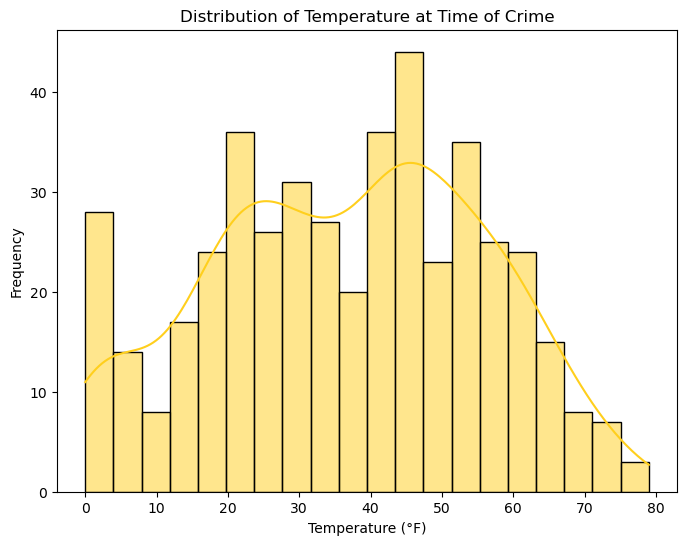

In [5]:
# Descriptive Stats
print("Temperature Stats:")
print(merged_df['Temperature'].describe())

# Visualization
plt.figure(figsize=(8,6))
sns.histplot(merged_df['Temperature'], bins=20, kde=True, color=colors[2])
plt.title('Distribution of Temperature at Time of Crime')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

### Humidity Analysis:


Humidity Stats:
count    451.000000
mean      68.325942
std       19.194275
min        0.000000
25%       57.000000
50%       72.000000
75%       81.000000
max      100.000000
Name: Humidity, dtype: float64


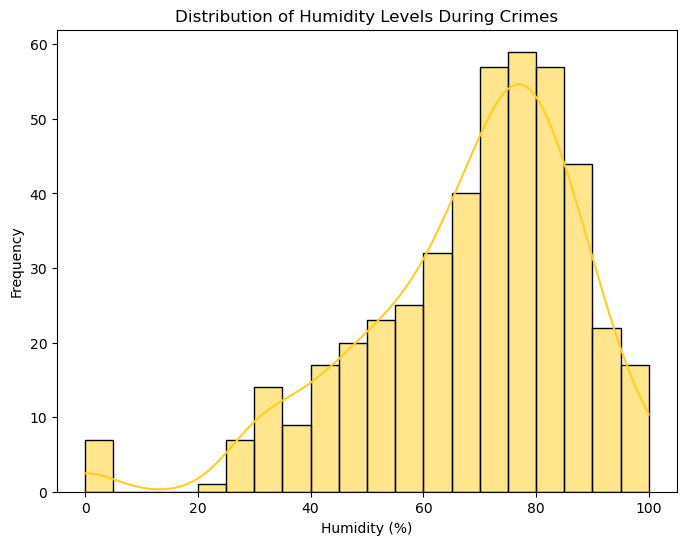

In [156]:
# Descriptive Stats
print("\nHumidity Stats:")
print(merged_df['Humidity'].describe())

# Visualization
plt.figure(figsize=(8,6))
sns.histplot(merged_df['Humidity'], bins=20, kde=True, color=colors[2])
plt.title('Distribution of Humidity Levels During Crimes')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.show()

### Wind Speed Analysis:


Wind Speed Stats:
count    451.000000
mean      12.700665
std        6.445772
min        0.000000
25%        8.000000
50%       13.000000
75%       16.000000
max       38.000000
Name: Wind Speed, dtype: float64


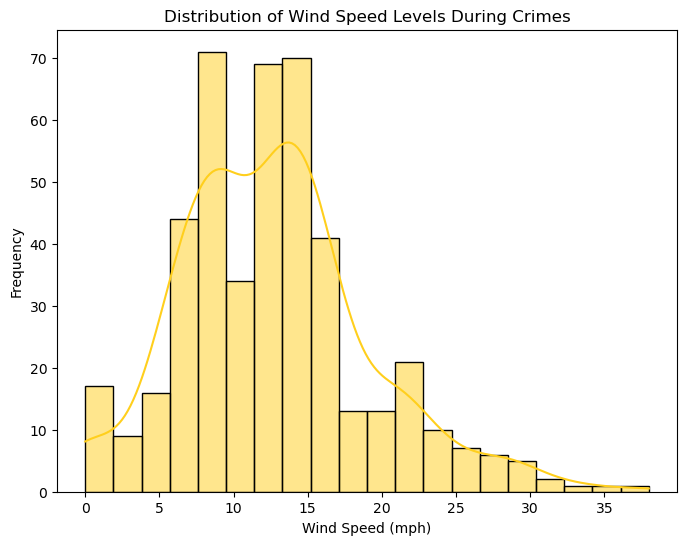

In [112]:
# Descriptive Stats
print("\nWind Speed Stats:")
print(merged_df['Wind Speed'].describe())

# Visualization
plt.figure(figsize=(8,6))
sns.histplot(merged_df['Wind Speed'], bins=20, kde=True, color=colors[2])
plt.title('Distribution of Wind Speed Levels During Crimes')
plt.xlabel('Wind Speed (mph)')
plt.ylabel('Frequency')
plt.show()

### Additional Univariate Visualizatons:

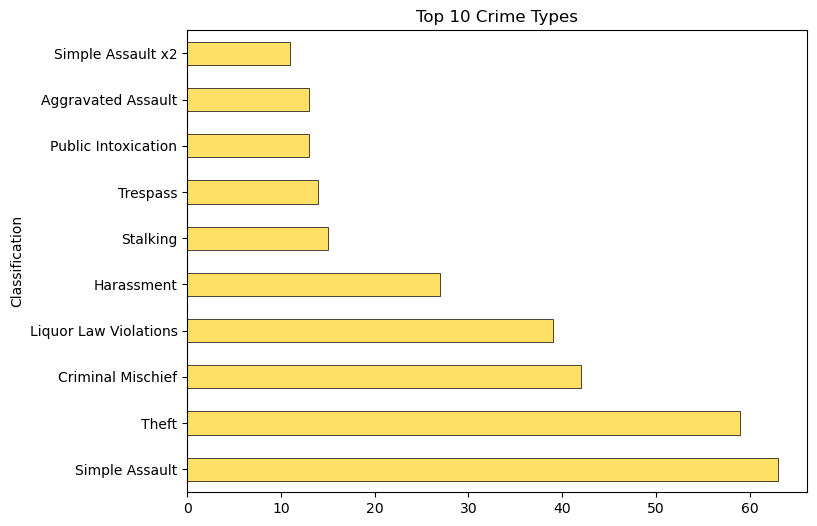

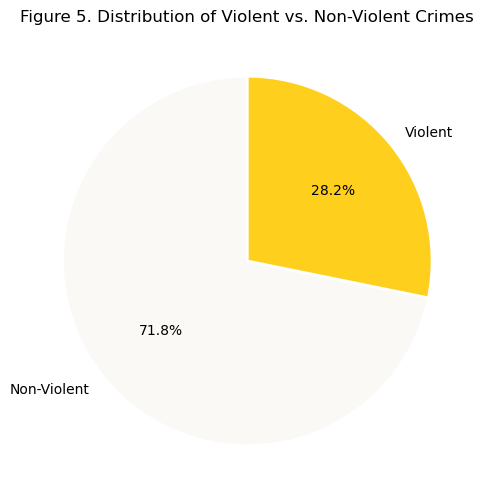

In [162]:
# Crime Type Counts
merged_df['Classification'].value_counts().head(10).plot(kind='barh', figsize=(8,6), edgecolor='black', color=colors[1], linewidth=0.5)
plt.title('Top 10 Crime Types')
plt.show()

# Violent vs. Non-Violent Crimes
crime_counts = merged_df['Violent Crime'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(crime_counts, 
        labels=['Non-Violent','Violent'], 
        startangle=90, 
        colors=(colors[0],colors[2]), 
        autopct='%1.1f%%',
       wedgeprops={'linewidth':2, 'edgecolor':'white'})
plt.title('Figure 5. Distribution of Violent vs. Non-Violent Crimes')
plt.show()

# 3.1 Temperature and Violent Crime

Hypothesis: There is a difference in average temperature between violent and non-violent crimes.

In [11]:
# split into groups
violent_temps = merged_df[merged_df['Violent Crime'] == 1]['Temperature']
nonviolent_temps = merged_df[merged_df['Violent Crime'] == 0]['Temperature']

# mean temperatures by group
print("Mean temp (violent):", violent_temps.mean())
print("Mean temp (non-violent):", nonviolent_temps.mean(), "\n")

# independent t-test
t_stat, p_value = stats.ttest_ind(violent_temps, nonviolent_temps, nan_policy='omit')

print(f"T-Statistic: {t_stat:.3f}")
print(f"P-Value: {p_value:.3f}")

# Interpret
if p_value < 0.05:
    print("\nThere IS a significant difference in temperature between violent and nonviolent crimes.")
else:
    print("\nThere is NO significant difference in temperature between violent and nonviolent crimes.")

Mean temp (violent): 36.515625
Mean temp (non-violent): 36.63467492260062 

T-Statistic: -0.060
P-Value: 0.952

There is NO significant difference in temperature between violent and nonviolent crimes.


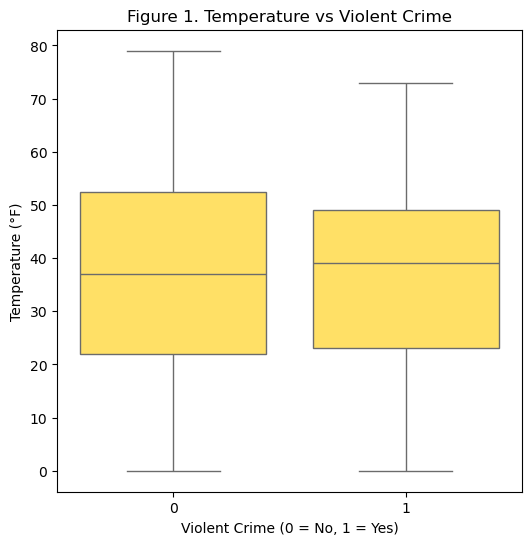

In [122]:
# Temperature vs Violent Crime (boxplot)
plt.figure(figsize=(6,6))
sns.boxplot(x='Violent Crime', y='Temperature', data=merged_df, color=colors[1], saturation=1)
plt.title('Figure 1. Temperature vs Violent Crime')
plt.xlabel('Violent Crime (0 = No, 1 = Yes)')
plt.ylabel('Temperature (°F)')
plt.show()

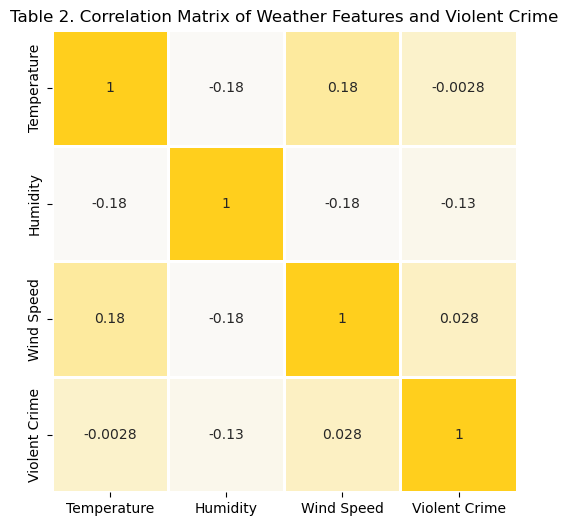

In [105]:
# correlation matrix
correlation = merged_df[['Temperature', 'Humidity', 'Wind Speed', 'Violent Crime']].corr()

plt.figure(figsize=(6,6))
sns.heatmap(correlation,
            annot=True,
            linewidths=1,
            cmap=yellow,
            cbar=False)
plt.title('Table 2. Correlation Matrix of Weather Features and Violent Crime')
plt.show()

# 3.2 Time of Day and Violent Crime

Hypothesis: There is a significant relationship between the Time of Day and Violent Crime

In [15]:
# create contingency table
contingency_table = pd.crosstab(merged_df['Time Bucket'], merged_df['Violent Crime'])
print("Contingency Table:\n",contingency_table,"\n")

# run chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# results
print(f"Chi-Square Statistic = {chi2:.4f}")
print(f"Degrees of Freedom = {dof}")
print(f"P-Value = {p_value:.5f}")

# interpret
if p_value < 0.05:
    print("\nResult: There IS a statistically significant relationship between Time of Day and Violent Crime.")
else:
    print("\nResult: There is NO statistically significant relationship between Time of Day and Violent Crime.")

Contingency Table:
 Violent Crime    0   1
Time Bucket           
Afternoon       83  49
Evening         65  33
Morning         76  38
Night          102   8 

Chi-Square Statistic = 31.9192
Degrees of Freedom = 3
P-Value = 0.00000

Result: There IS a statistically significant relationship between Time of Day and Violent Crime.


Afternoon and Morning have **more violent crimes** compared to other times

Night has **many** crimes, but very few are violent (only 8 violent crimes out of 110 total at night)

This means:
- Crimes that happen **at Night** tend to be **non-violent**
- Violent crimes are **more likely** in the **Afternoon or Morning**

### Figure 2. Barchart of Proportion of Violent Crimes by Time of Day

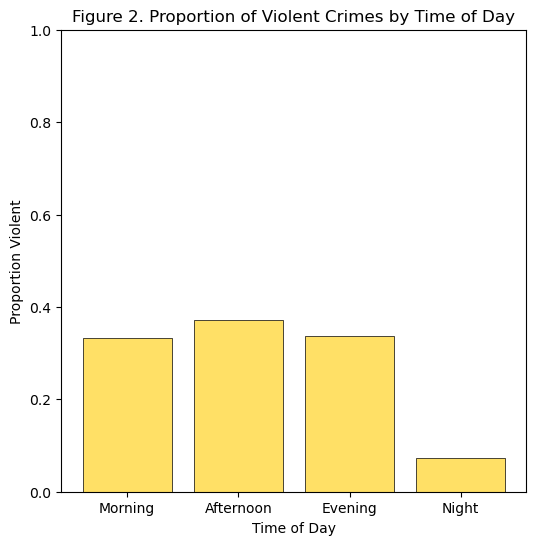

In [133]:
# correct the order for Time of Day
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# plot the proportion of Violent Crimes per Time of Day
violent_proportions = contingency_table[1] / (contingency_table[0] + contingency_table[1])

# reindex so it's in the correct order
violent_proportions = violent_proportions.reindex(time_order)

# plot
# violent_proportions.plot(kind='bar', figsize=(6,6), color=colors[1])
plt.figure(figsize=(6,6))
bars = plt.bar(violent_proportions.index,
               violent_proportions.values,
               color=colors[1],
               edgecolor='black',
               linewidth=0.5)

plt.title('Figure 2. Proportion of Violent Crimes by Time of Day')
plt.ylabel('Proportion Violent')
plt.xlabel('Time of Day')
plt.ylim(0,1)
plt.show()

### Figure 3. Heatmap of Crime Type by Time Bucket
Figure out which types of crimes are most common at different times of day

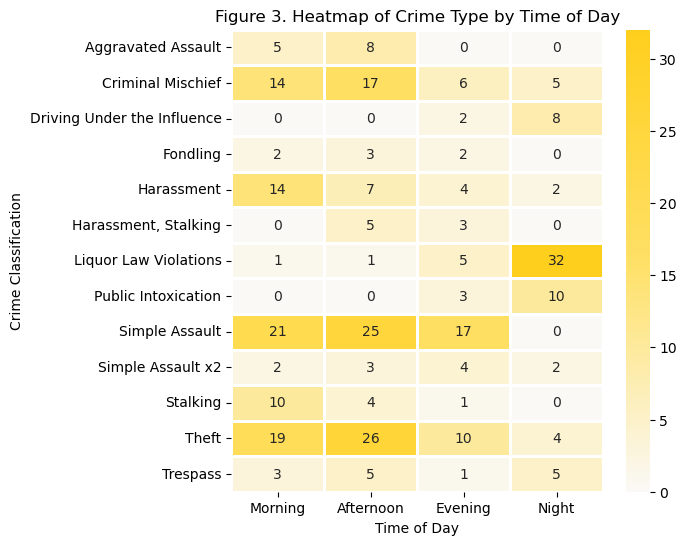

In [165]:
# filter to crime types with more than 5 reports
crime_counts = merged_df['Classification'].value_counts()
top_crimes = crime_counts[crime_counts > 5].index
filtered_df = merged_df[merged_df['Classification'].isin(top_crimes)]

# pivot table (crime type by time bucket)
crime_time = pd.crosstab(filtered_df['Classification'], filtered_df['Time Bucket'])

# reorder time columns (did time_order earlier)
crime_time = crime_time[time_order]

# heatmap
plt.figure(figsize=(6,6))
sns.heatmap(crime_time,
            cmap=yellow,
            annot=True,
            fmt='d',
            linewidths=1,
            linecolor='white')
plt.title('Figure 3. Heatmap of Crime Type by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Crime Classification')
plt.show()

# 3.3 Predictive Modeling of Violent Crime

### Logistic Regression:

Accuracy: 0.6838235294117647
              precision    recall  f1-score   support

           0       0.69      0.99      0.81        93
           1       0.50      0.02      0.04        43

    accuracy                           0.68       136
   macro avg       0.59      0.51      0.43       136
weighted avg       0.63      0.68      0.57       136

Pseudo R-squared: -0.0003


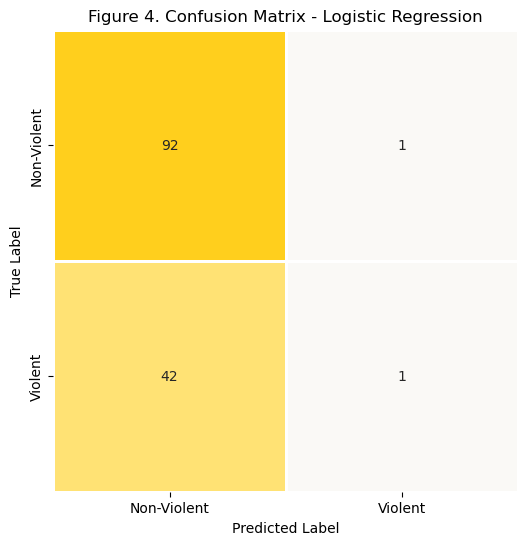

In [161]:
# prepare features and target
features = merged_df[['Temperature', 'Humidity', 'Wind Speed']].dropna()
target = merged_df.loc[features.index, 'Violent Crime']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# build and train model
model = LogisticRegression()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# pseudo r-squared calculation
null_deviance = log_loss(y_test, np.full(y_test.shape, y_test.mean()))
deviance = log_loss(y_test, model.predict_proba(X_test)[:,1])
pseudo_r_squared = 1 - (deviance / null_deviance)
print(f"Pseudo R-squared: {pseudo_r_squared:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap=yellow,
            linewidths=1,
            cbar=False,
            xticklabels=['Non-Violent','Violent'],
            yticklabels=['Non-Violent','Violent'])
plt.title('Figure 4. Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Violent crimes are predicted correctly less than 10% of the time

The Pseudo R-squared suggests that the model fits worse than a simple baseline model.

This shows that weather variables (temperature, humidity, and wind speed) alone are poor predictors of violent crime

### KNN:

KNN Accuracy: 0.6764705882352942

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.89      0.79        93
           1       0.47      0.21      0.29        43

    accuracy                           0.68       136
   macro avg       0.59      0.55      0.54       136
weighted avg       0.63      0.68      0.63       136



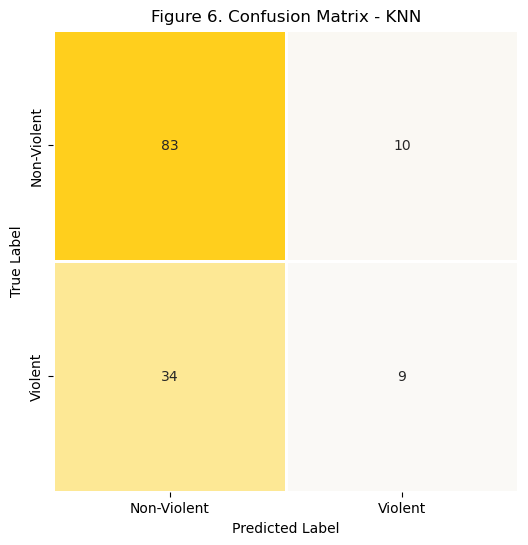

In [163]:
# initialize KNN
knn = KNeighborsClassifier(n_neighbors=5)

# fit KNN
knn.fit(X_train, y_train)

# predict with KNN
y_knn_pred = knn.predict(X_test)

# evaluate
print("KNN Accuracy:", accuracy_score(y_test, y_knn_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_knn_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_knn_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap=yellow,
            linewidths=1,
            cbar=False,
            xticklabels=['Non-Violent','Violent'],
            yticklabels=['Non-Violent','Violent'])
plt.title('Figure 6. Confusion Matrix - KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Both of these models struggle badly to predict violent crimes.

### Weighted Logistic Regression

Weighted Accuracy: 0.5294117647058824 

              precision    recall  f1-score   support

           0       0.70      0.55      0.61        93
           1       0.33      0.49      0.40        43

    accuracy                           0.53       136
   macro avg       0.52      0.52      0.51       136
weighted avg       0.58      0.53      0.55       136

Pseudo R-squared: -0.1181


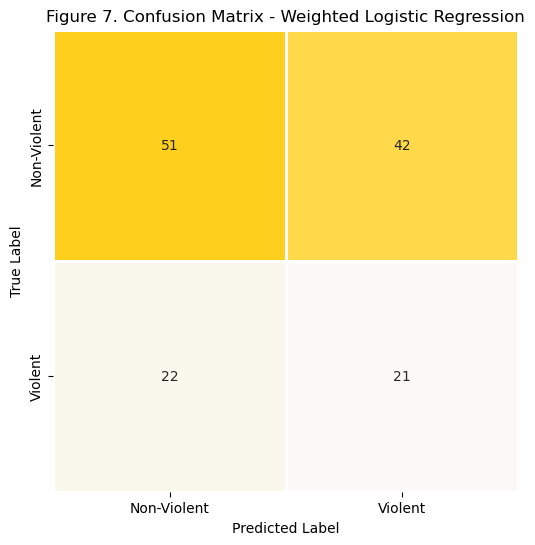

In [164]:
# apply class weighting
weighted_model = LogisticRegression(class_weight='balanced')
weighted_model.fit(X_train, y_train)

# predict and eval
weighted_preds = weighted_model.predict(X_test)
print("Weighted Accuracy:", accuracy_score(y_test, weighted_preds), "\n")
print(classification_report(y_test, weighted_preds))


# pseudo r-squared calculation
null_deviance = log_loss(y_test, np.full(y_test.shape, y_test.mean()))
deviance = log_loss(y_test, weighted_model.predict_proba(X_test)[:,1])
pseudo_r_squared = 1 - (deviance / null_deviance)
print(f"Pseudo R-squared: {pseudo_r_squared:.4f}")

# confusion matrix
cm_weighted = confusion_matrix(y_test, weighted_preds)

plt.figure(figsize=(6,6))
sns.heatmap(cm_weighted,
            annot=True,
            fmt='d',
            cmap=yellow,
            linewidths=1,
            cbar=False,
            xticklabels=['Non-Violent','Violent'],
            yticklabels=['Non-Violent','Violent'])
plt.title('Figure 7. Confusion Matrix - Weighted Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()